[2025/05/02 16:42:30] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\User/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\User/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', re

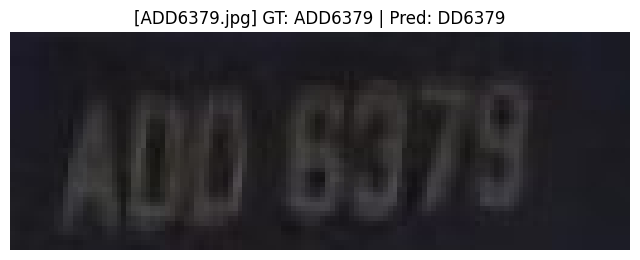

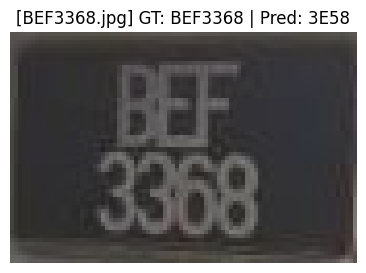

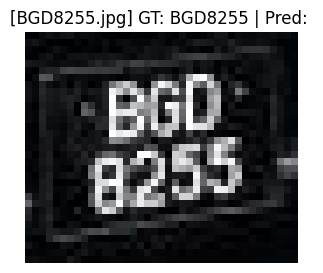

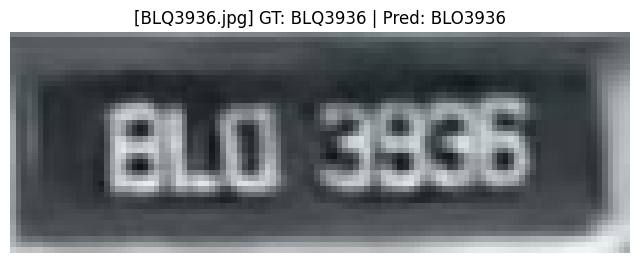

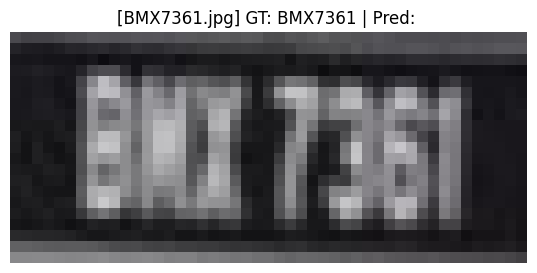

In [2]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

# 📁 Dataset path
dataset_path = r"C:\Users\User\Downloads\RealTimeAIMalaysianCarplateDetection\CarPlateForOCR\Dataset"
subfolders = ['train', 'test']

# 🧠 Initialize PaddleOCR (use_angle_cls=True enables angle correction)
ocr = PaddleOCR(use_angle_cls=True, lang='en',use_gpu=True)  # use_gpu=True for GPU

# 📊 Store results
results = []
failed_samples = []

# 🔁 Loop through train/test images
for sub in subfolders:
    folder = os.path.join(dataset_path, sub)
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder, filename)
            ground_truth = os.path.splitext(filename)[0].upper().replace(" ", "")

            # 🔍 Run OCR
            result = ocr.ocr(image_path, cls=True)

            # 📝 Extract predicted text
            detected_text = ""
            if result and isinstance(result, list):
                for line in result:
                    if isinstance(line, list):
                        for box, text in line:
                            detected_text += text[0]

            detected_text = detected_text.upper().replace(" ", "")

            # ✅ Evaluate
            match = detected_text == ground_truth
            result_entry = {
                "file": filename,
                "folder": sub,
                "ground_truth": ground_truth,
                "predicted": detected_text,
                "match": match
            }
            results.append(result_entry)

            if not match:
                failed_samples.append((filename, image_path, ground_truth, detected_text))

            print(f"[{filename}] GT: {ground_truth} | Pred: {detected_text} | {'✅' if match else '❌'}")

# 🧮 Final accuracy
total = len(results)
correct = sum(r["match"] for r in results)
accuracy = correct / total * 100
print(f"\n🔍 Total: {total} | Correct: {correct} | Accuracy: {accuracy:.2f}%")

# 💾 Save results to Excel
df = pd.DataFrame(results)
output_file = os.path.join(dataset_path, "paddleocr_results.xlsx")
df.to_excel(output_file, index=False)
print(f"📁 Results saved to: {output_file}")

# 🖼️ Show a few failed predictions
print("\n🔍 Showing up to 5 failed predictions:")
for i, (fname, img_path, gt, pred) in enumerate(failed_samples[:5]):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 3))
    plt.imshow(img_rgb)
    plt.title(f"[{fname}] GT: {gt} | Pred: {pred}")
    plt.axis("off")
    plt.show()
